# **Installs & Imports**

In [ ]:
!pip install rioxarray -q

In [ ]:
import numpy as np
import matplotlib.pyplot as pyplot
import rioxarray
import xarray
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Setup plotting parameters
pyplot.style.use("https://raw.githubusercontent.com/HatefDastour/matplotlib_custom_style/main/custom_style.mplstyle")

# **1. Data Loading & Inspection**

In [ ]:
ls -l

total 31412
-rw-r--r-- 1 root root  5173031 Nov  7 15:24 Landsat8_and9_2023_Apr_Oct_swir.tif
-rw-r--r-- 1 root root 26985041 Nov  7 15:24 s2_FresnoCalifornia_2023_swir.tif
drwxr-xr-x 1 root root     4096 Nov  5 14:33 sample_data/


In [ ]:
sentinel2_path = Path("./s2_FresnoCalifornia_2023_swir.tif")
landsat_path = Path("./Landsat8_and9_2023_Apr_Oct_swir.tif")

def load_data_from_file(filepath, data_name="Data"):
    print(f"\nLoading {data_name} data...")
    data = rioxarray.open_rasterio(filepath, chunks=True)
    bands = [int(band) if not isinstance(band,int) else band for band in data.band.values] # Convert to simple ints if elements not already in int format
    print(f"{data_name} shape = {data.shape}")
    print(f"{data_name} bands = {list(bands)}")
    print(f"{data_name} CRS = {data.rio.crs}")
    print(f"{data_name} resolution = {data.rio.resolution()}")
    return data

sentinel2_data = load_data_from_file(sentinel2_path, "Sentinel-2")
landsat_data = load_data_from_file(landsat_path, "Landsat 8 and 9")


Loading Sentinel-2 data...
Sentinel-2 shape = (5, 1416, 1582)
Sentinel-2 bands = [1, 2, 3, 4, 5]
Sentinel-2 CRS = EPSG:32611
Sentinel-2 resolution = (10.0, -10.0)

Loading Landsat 8 and 9 data...
Landsat 8 and 9 shape = (5, 472, 528)
Landsat 8 and 9 bands = [1, 2, 3, 4, 5]
Landsat 8 and 9 CRS = EPSG:32611
Landsat 8 and 9 resolution = (30.0, -30.0)


## **Band extraction & naming**
* BLUE = b2 = `band=1` = index 0
* GREEN = b3 = `band=2` = index 1
* RED = b4 = `band=3` = index 2
* NIR = b8 = `band=4` = index 3
* SWIR = b11 or b6 = `band5` = index 4

`bands = [BLUE, GREEN, RED, NIR, SWIR]`

In [ ]:
def extract_bands(data, bands_count, reflectance_scale=1):
    bands = []
    for i in range(1, bands_count+1):
        band = data.sel(band=i) / reflectance_scale
        bands.append(band)
    return bands

def print_band_range(band_data, data_name="Data"):
    print(f"{data_name}: {band_data.min().values:.4f} (min) to {band_data.max().values:.4f} (max)")
sentinel2_bands = extract_bands(sentinel2_data, 5, reflectance_scale=1e4)
landsat_bands = extract_bands(landsat_data, 5, reflectance_scale=1)

print(f"Red bands:")
print_band_range(sentinel2_bands[2], data_name="Sentinel-2")
print_band_range(landsat_bands[2], data_name="Landsat 8 and 9")

Red bands:
Sentinel-2: 0.0016 (min) to 0.8052 (max)
Landsat 8 and 9: 0.0172 (min) to 0.6128 (max)


# **2. Function Implementation**
To prevent division-by-zero errors, the `prevent_division_by_0()` function takes any denominator of xarray.DataArrayObject and converts any values that equal 0 to NaN. Later on, when plotting the histogram of index value distributions, the NaNs are exluded.

In [ ]:
def mask_range(min: int, max: int, array):
    """ Returns values from array within min to max range only."""
    return array.where((array >= min) & (array <= max))

def prevent_division_by_0(denominator):
    """ Returns values from denominator (xarray.DataArray) except 0 values are replaced with NaN (to prevent division by 0 errors)"""
    return denominator.where(denominator != 0, np.nan)

def xarray_division(numerator, denominator):
    """Performs numerator/denomintor for xarrays. Prevent division by 0 errors AND restricts all values within -1 to 1 range"""
    denominator = prevent_division_by_0(denominator)
    result = numerator / denominator
    result =  mask_range(-1, 1, result)
    return result

In [ ]:
def calculate_gndvi(nir, green):
    """Calculate Green Normalized Difference Vegetation Index (GNDVI) using standard formula: GNDVI = (NIR - Green) / (NIR + Green)
    Parameters:
        nir: xarray.DataArray
            DataArray contains near-infrared (NIR) band reflectance values.
        green: xarray.DataArray
            DataArray contains green band reflectance values.
    Returns:
        xarray.DataArray
            DataArray of NDVI values, ranging from -1 to 1. Invalid results (e.g., divide by zero) are set to NaN.
    """
    numerator = nir - green
    denominator = nir + green
    gndvi = xarray_division(numerator, denominator)
    gndvi.name = "GNDVI" # Add metadata
    return gndvi

def calculate_mndwi(green, swir):
    """Calculate Modified Normalized Difference Water Index (MNDWI) using standard formula: MNDWI = (Green - SWIR) / (Green + SWIR)
    Parameters:
        green: xarray.DataArray
            DataArray contains green band reflectance values.
        swir: xarray.DataArray
            DataArray contains shortwave-infrared (SWIR) band reflectance values.
    Returns:
        xarray.DataArray
            DataArray of MNDWI values, ranging from -1 to 1. Invalid results (e.g., divide by zero) are set to NaN.
    """
    numerator = green - swir
    denominator = green + swir
    mndwi = xarray_division(numerator, denominator)
    mndwi.name = "MNDWI" # Add metadata
    return mndwi

def calculate_ndbi(swir, nir):
    """Calculate Normalized Difference Built-up Index (NDBI) using standard formula: NDBI = (SWIR - NIR) / (SWIR + NIR)
    Parameters:
        swir: xarray.DataArray
            DataArray contains shortwave-infrared (SWIR) band reflectance values.
        nir: xarray.DataArray
            DataArray contains near-infrared (NIR) band reflectance values.

    Returns:
        xarray.DataArray
            DataArray of NDBI values, ranging from -1 to 1. Invalid results (e.g., divide by zero) are set to NaN.
    """
    numerator = swir -  nir
    denominator = swir + nir
    ndbi = xarray_division(numerator, denominator)
    ndbi.name = "NDBI" # Add metadata
    return ndbi


def calculate_ndmi(nir, swir):
    """Calculate Normalized Difference Moisture Index (NDMI) using standard formula: NMDI = (NIR - SWIR) / (NIR + SWIR)
    Parameters:
        nir: xarray.DataArray
            DataArray contains near-infrared (NIR) band reflectance values.
        swir: xarray.DataArray
            DataArray contains shortwave-infrared (SWIR) band reflectance values.

    Returns:
        xarray.DataArray
            DataArray of NDMI values, ranging from -1 to 1. Invalid results (e.g., divide by zero) are set to NaN.
    """
    numerator = nir - swir
    denominator = nir + swir
    ndmi = xarray_division(numerator, denominator)
    ndmi.name = "NDMI" # Add metadata
    return ndmi

# **3. Index Calculations**

**Brief observations about value ranges...**

The Sentinel-2 and Landsat GNDVI values are mostly positive (with Landsat showing slightly higher mean and median values), indicating healthy vegetation.

MNDWI values are mostly negative for both sensors (with Sentinel-2 showing wider range variance), indicating the few amount of water bodies present in Fresno, California.

NDBI values are close to zero, slightly skewing to the negatives, indicating that the location has a more vegetative than urban landcover.

NDMI values have a low positive mean, indicating that the vegetation in the location is primarily dry to moderately moist.

In [ ]:
sentinel2_gndvi = calculate_gndvi(sentinel2_bands[3], sentinel2_bands[0])
landsat_gndvi = calculate_gndvi(landsat_bands[3], landsat_bands[0])

sentinel2_mndwi = calculate_mndwi(sentinel2_bands[0], sentinel2_bands[4])
landsat_mndwi = calculate_mndwi(landsat_bands[0], landsat_bands[4])

sentinel2_ndbi = calculate_ndbi(sentinel2_bands[4], sentinel2_bands[3])
landsat_ndbi = calculate_ndbi(landsat_bands[4], landsat_bands[3])

sentinel2_ndmi = calculate_ndmi(sentinel2_bands[3], sentinel2_bands[4])
landsat_ndmi = calculate_ndmi(landsat_bands[3], landsat_bands[4])

In [ ]:
def calculate_statistics(index, sensor_index_name):
    """Calculate and display basic statistics for an index."""
    # Remove NaN values for statistics
    valid_data = index.values[~np.isnan(index.values)]

    if len(valid_data) > 0:
        stats = {
            'count': len(valid_data),
            'mean': np.mean(valid_data),
            'std': np.std(valid_data),
            'min': np.min(valid_data),
            'max': np.max(valid_data),
            'median': np.median(valid_data)
        }

        print(f"\n{sensor_index_name} Statistics:")
        print(f"  Valid pixels: {stats['count']:,}")
        print(f"  Mean: {stats['mean']:.4f}")
        print(f"  Std Dev: {stats['std']:.4f}")
        print(f"  Min: {stats['min']:.4f}")
        print(f"  Max: {stats['max']:.4f}")
        print(f"  Median: {stats['median']:.4f}")

        return stats
    else:
        print(f"\n{sensor_index_name}: No valid data found")
        return None

In [ ]:
print("=== STATISTICAL ANALYSIS ===")
calculate_statistics(sentinel2_gndvi, "Sentinel-2 GNDVI")
calculate_statistics(landsat_gndvi, "Landsat 8 and 9 GNDVI")
print()
calculate_statistics(sentinel2_mndwi, "Sentinel-2 MNDWI")
calculate_statistics(landsat_mndwi, "Landsat 8 and 9 MNDWI")
print()
calculate_statistics(sentinel2_ndbi, "Sentinel-2 NDBI")
calculate_statistics(landsat_ndbi, "Landsat 8 and 9 NDBI")
print()
calculate_statistics(sentinel2_ndmi, "Sentinel-2 NDMI")
calculate_statistics(landsat_ndmi, "Landsat 8 and 9 NDMI")

=== STATISTICAL ANALYSIS ===

Sentinel-2 GNDVI Statistics:
  Valid pixels: 2,111,907
  Mean: 0.6121
  Std Dev: 0.2112
  Min: -1.0000
  Max: 0.9474
  Median: 0.6444

Landsat 8 and 9 GNDVI Statistics:
  Valid pixels: 235,182
  Mean: 0.6648
  Std Dev: 0.1423
  Min: -0.1059
  Max: 0.9248
  Median: 0.6747


Sentinel-2 MNDWI Statistics:
  Valid pixels: 2,111,907
  Mean: -0.5903
  Std Dev: 0.1561
  Min: -0.8902
  Max: 0.7730
  Median: -0.6215

Landsat 8 and 9 MNDWI Statistics:
  Valid pixels: 235,182
  Mean: -0.6128
  Std Dev: 0.0950
  Min: -0.8857
  Max: 0.6911
  Median: -0.6289


Sentinel-2 NDBI Statistics:
  Valid pixels: 2,111,907
  Mean: -0.0748
  Std Dev: 0.1673
  Min: -0.7793
  Max: 1.0000
  Median: -0.0553

Landsat 8 and 9 NDBI Statistics:
  Valid pixels: 235,183
  Mean: -0.1189
  Std Dev: 0.1560
  Min: -0.8617
  Max: 0.3582
  Median: -0.0944


Sentinel-2 NDMI Statistics:
  Valid pixels: 2,111,907
  Mean: 0.0748
  Std Dev: 0.1673
  Min: -1.0000
  Max: 0.7793
  Median: 0.0553

Landsat 

{'count': 235183,
 'mean': np.float32(0.118867725),
 'std': np.float32(0.15603906),
 'min': np.float32(-0.35822305),
 'max': np.float32(0.8617271),
 'median': np.float32(0.09440671)}

# **4. Visualization Grids**
**Brief description of interesting spatial patterns...**

Sentinel-2 NDBI visualization captured a dark outline around some of the water bodies while Landsat 89 NDBI visualization did not. This could suggest that the water bodies are man-made water reservoirs or recharge basins.

Sentinel-2 NDMI visualization captured more moisture detail than Landsat 8/9 NDMI visualization as can be seen by the slightly more orange overall northeast corner (including a few very red squares) in Sentinel-2 NDMI visualization compared to its Landsat counterpart which did not present this degree of variance.


In [ ]:
def get_colormap_and_range(index_name):
    """Return colormap & value range for each index"""
    colormaps = {
        "GNDVI": ("RdYlGn", -0.5, 1.0),
        "MNDWI": ("RdBu", -0.8, 0),
        "NDBI": ("Reds", -0.75, 0.4),
        "NDMI": ("RdYlBu", -0.5, 0.6)
    }
    return colormaps.get(index_name, ("viridis", None, None))

def plot_index_comparison(s2_index, l_index, title):
    """Plot side-by-side comparison of indices with longitude/latitude coordinates."""
    cmap, vmin, vmax = get_colormap_and_range(title)

    fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(15, 6), sharey=True)

    # Convert to geographic coordinates (WGS84) if not already
    if s2_index.rio.crs != "EPSG:4326":
        s2_index_geo = s2_index.rio.reproject("EPSG:4326")
    else:
        s2_index_geo = s2_index

    if l_index.rio.crs != "EPSG:4326":
        l_index_geo = l_index.rio.reproject("EPSG:4326")
    else:
        l_index_geo = l_index

    # Get coordinate bounds for extent
    s2_left, s2_bottom, s2_right, s2_top = s2_index_geo.rio.bounds()
    l_left, l_bottom, l_right, l_top = l_index_geo.rio.bounds()

    # Define common axis properties
    common_axis_props = {
        "xlabel": "Longitude (°)",
        "aspect": "equal"
    }

    # Sentinel-2 plot
    im1 = ax1.imshow(s2_index_geo.values, cmap=cmap, vmin=vmin, vmax=vmax,
                     extent=[s2_left, s2_right, s2_bottom, s2_top], aspect="auto")
    ax1.set_title(f"Sentinel-2 {title}", fontsize=14, fontweight="bold")
    ax1.set(ylabel="Latitude (°)", **common_axis_props)
    ax1.set_adjustable("box")
    ax1.tick_params(axis="x", labelrotation=90)

    # Landsat plot
    im2 = ax2.imshow(l_index_geo.values, cmap=cmap, vmin=vmin, vmax=vmax,
                     extent=[l_left, l_right, l_bottom, l_top], aspect="auto")
    ax2.set_title(f"Landsat 8/9 {title}", fontsize=14, fontweight="bold")
    ax2.set(**common_axis_props)
    ax2.set_adjustable("box")
    ax2.tick_params(axis="x", labelrotation=90)

    # Use tight_layout first, then add colorbar
    pyplot.tight_layout()

    # Add colorbar to the right of the figure
    cbar = fig.colorbar(im1, ax=[ax1, ax2], shrink=0.6, aspect=30, pad=0.02)
    cbar.set_label(f"{title} Value", rotation=90, labelpad=5)

    pyplot.show()

Displaying spectral index results...


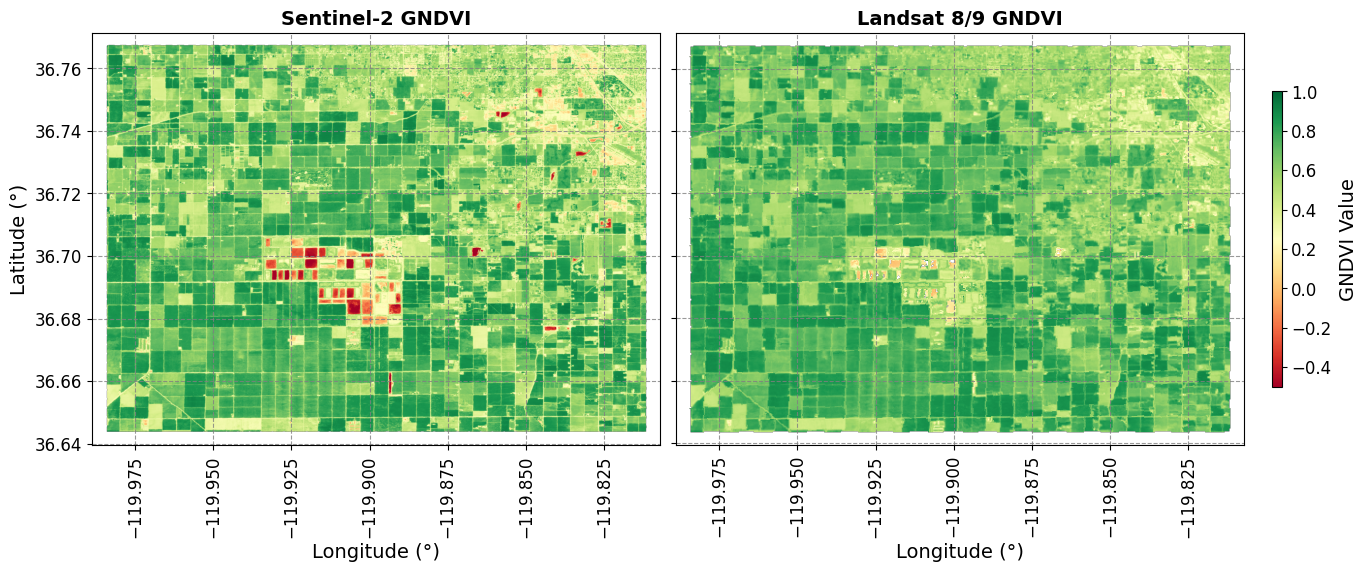

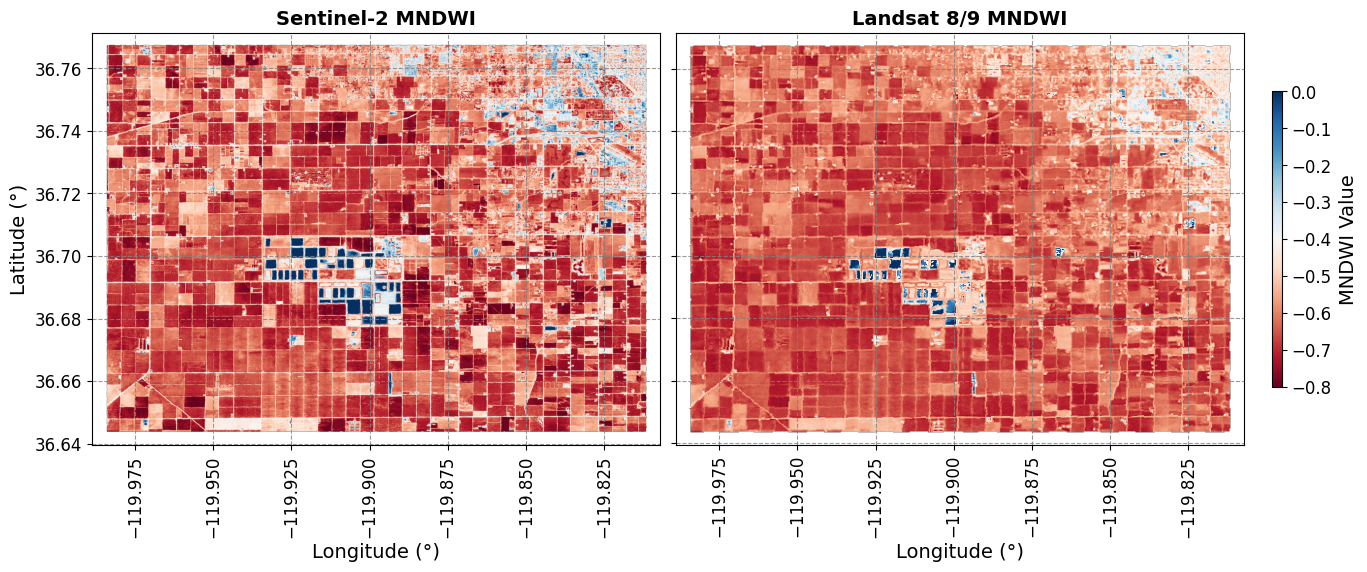

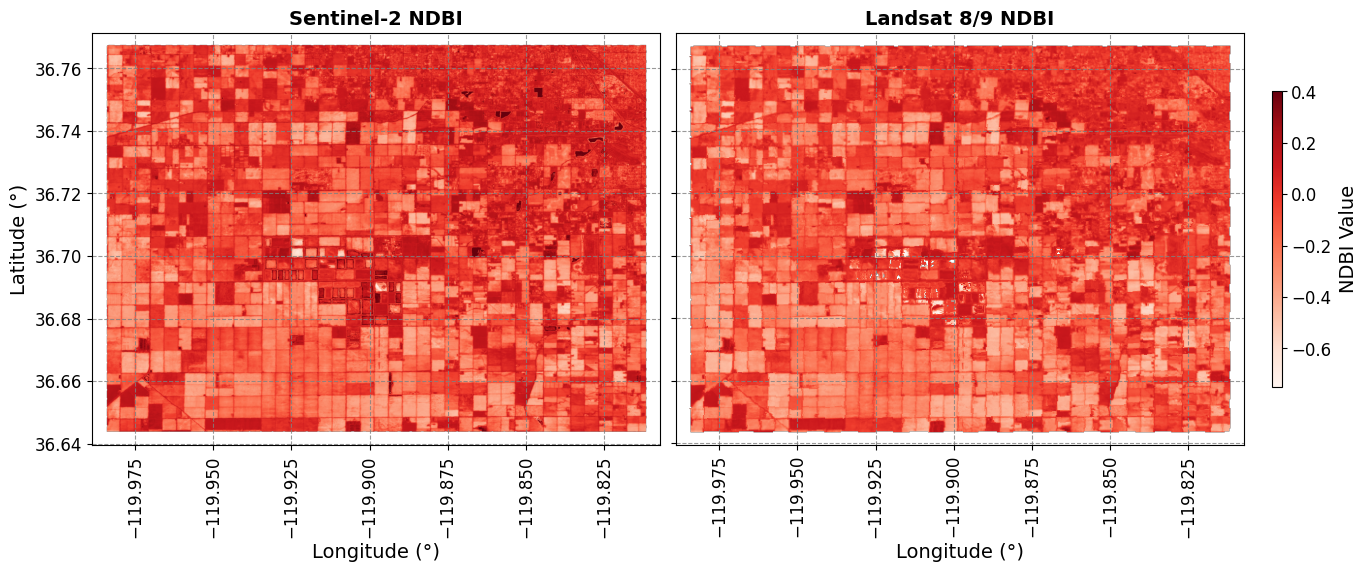

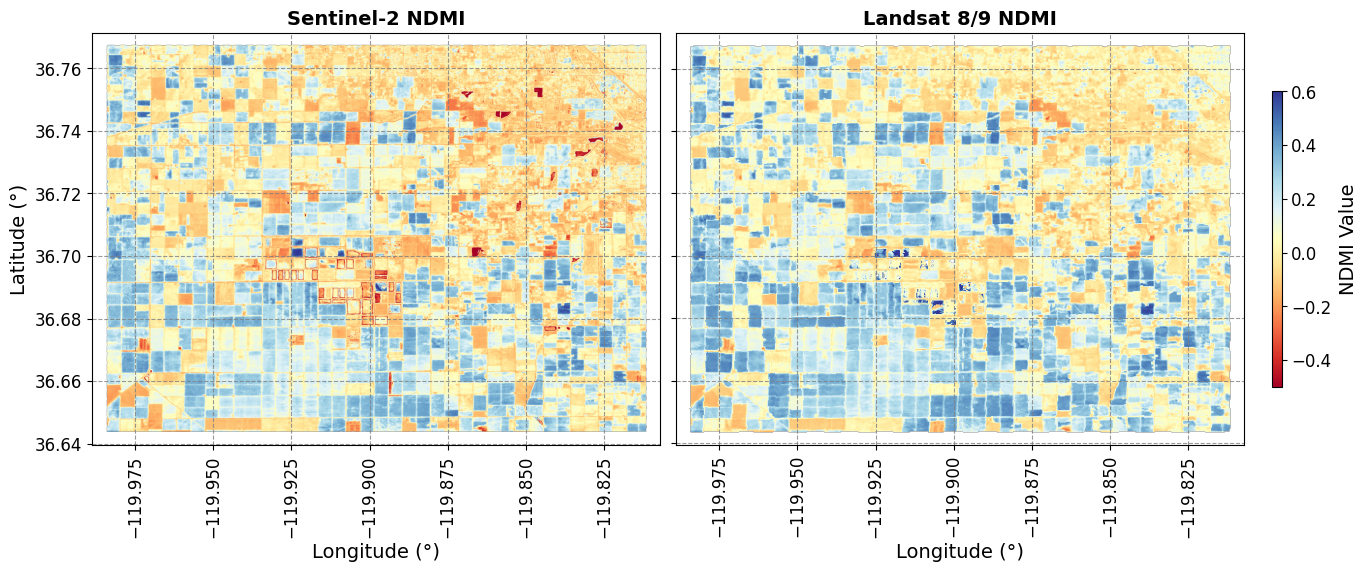

In [ ]:
# Plot all spectral indices
print("Displaying spectral index results...")

plot_index_comparison(sentinel2_gndvi, landsat_gndvi, "GNDVI")
plot_index_comparison(sentinel2_mndwi, landsat_mndwi, "MNDWI")
plot_index_comparison(sentinel2_ndbi, landsat_ndbi, "NDBI")
plot_index_comparison(sentinel2_ndmi, landsat_ndmi, "NDMI")

# **5. Sensor Comparison**
An in-depth analysis on the MNDWI indicies indicates that the usage of shortwave-infrared values instead of near-infrared values for the index formula can help capture a larger variance compared to the NDWI visualization generated in a301. In the NDWI viualization from a301, the visualization had little variance. In MNDWI Sentinel-2 and Landsat 8/9 visualizations, the colors vary more.

a301 visualization for NDWI:
image.png


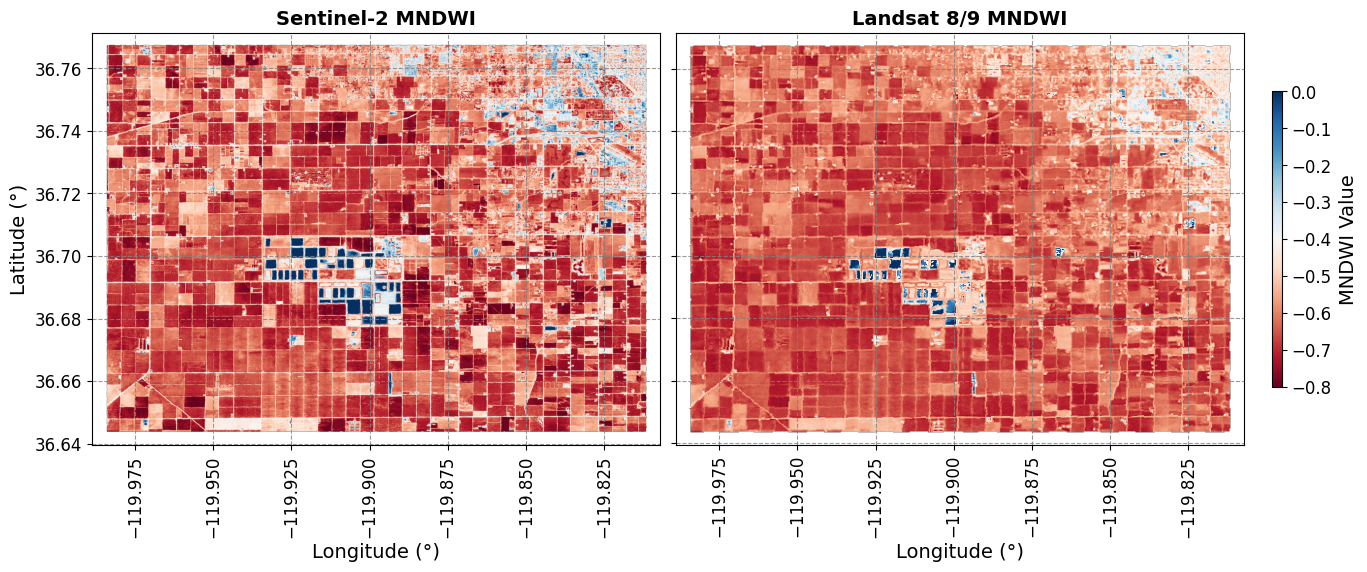

In [ ]:
plot_index_comparison(sentinel2_mndwi, landsat_mndwi, "MNDWI")

# **6. Statistical Analysis and Interpretation**

## Part A: Index Interpretation

GNDVI Analysis: Sentinel-2 and Landsat 8/9 GNDVI visualizations presents mostly light green colors. This aligns with expectations because the vegetation landcover in Fresno, California is mainly drier and sparse to moderately dense. Darker green areas represents vegetation with higher water and nitrogen uptake compared to lighter areas

MNDWI Analysis: The water bodies are mostly in the center of the selected area of interest which is successfully identified by both Sentinel-2 and Landsat 8/9 MNDWI visualizations. Although Landsat 8/9 captured less water bodies than Sentinel-2. Both of these match the NDWI visualized in a301. There are generally no false positives.

NDBI Analysis: The urban/built-up areas in the study area is in the northeast corner. NDBI was able to highlight them successively and aligns well with the known urban built-up in the area.

NDMI Analysis: NDMI visualizations above indicate that the southern fields in the studied interest area has more overall moisture than the northern fields. In particular, areas around the central water bodies are drier.

## Part B: Sensor Comparison
The Sentinel-2 and Landsat GNDVI values are mostly positive (with Landsat showing slightly higher mean and median values), indicating healthy vegetation. MNDWI values are mostly negative for both sensors (with Sentinel-2 showing wider range variance), indicating the few amount of water bodies present in Fresno, California. NDBI values are close to zero, slightly skewing to the negatives, indicating that the location has a more vegetative than urban landcover. NDMI values have a low positive mean, indicating that the vegetation in the location is primarily dry to moderately moist.

The spatial resolution from Sentinel-2 data was higher, therefore it could capture more variance than Landsat 8/9. This indicates that for any finer-detailed study objectives Sentinel-2 would be a better dataset to analyse from.

**Better ranges for each index base on selected study area**:
* GNDVI = [-0.5, 1.0]
* MNDWI = [-0.8, 0]
* NDBI = [-0.75, 0.4]
* NDMI = [-0.5, 0.6]

In [ ]:
def plot_histogram_comparison(s2_index, l_index, title):
    """Plot histograms comparing index distributions between sensors."""
    fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(15, 5))

    # Remove NaN values
    s2_valid = s2_index.values[~np.isnan(s2_index.values)]
    l_valid = l_index.values[~np.isnan(l_index.values)]

    # Sentinel-2 histogram
    ax1.hist(s2_valid, bins=50, alpha=0.7, color="blue", edgecolor="black")
    ax1.set_title(f"Sentinel-2 {title} Distribution")
    ax1.set_xlabel(f"{title} Value")
    ax1.set_ylabel("Frequency")
    ax1.grid(True, alpha=0.3)

    # Landsat histogram
    ax2.hist(l_valid, bins=50, alpha=0.7, color="red", edgecolor="black")
    ax2.set_title(f"Landsat 8/9 {title} Distribution")
    ax2.set_xlabel(f"{title} Value")
    ax2.set_ylabel("Frequency")
    ax2.grid(True, alpha=0.3)

    pyplot.tight_layout()
    pyplot.show()

Creating histogram comparisons...


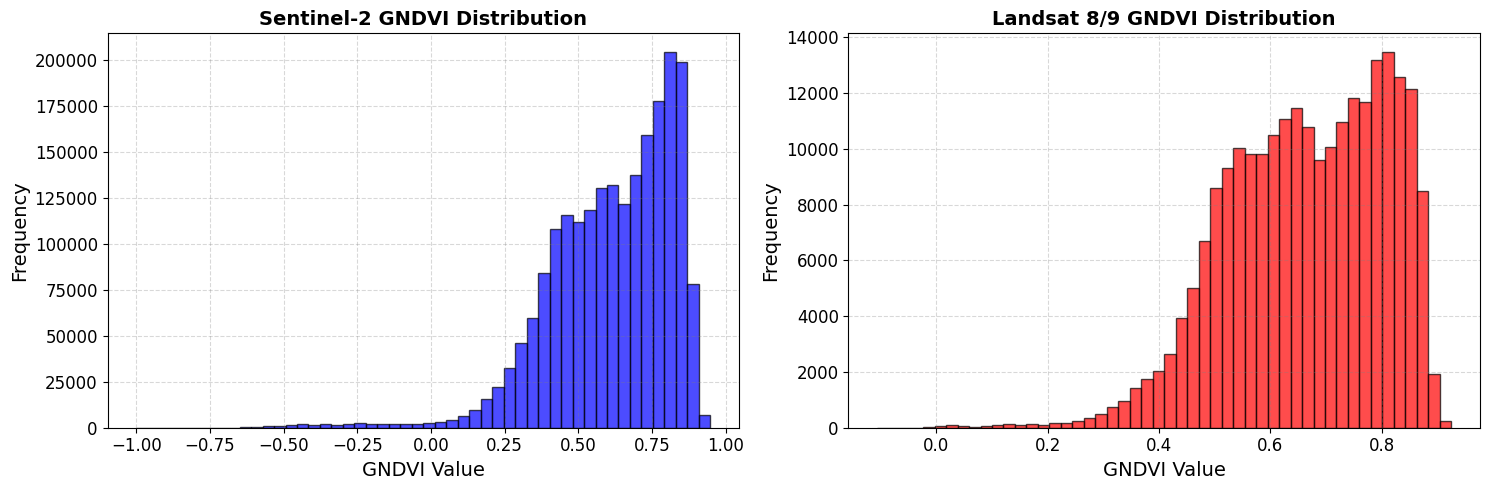

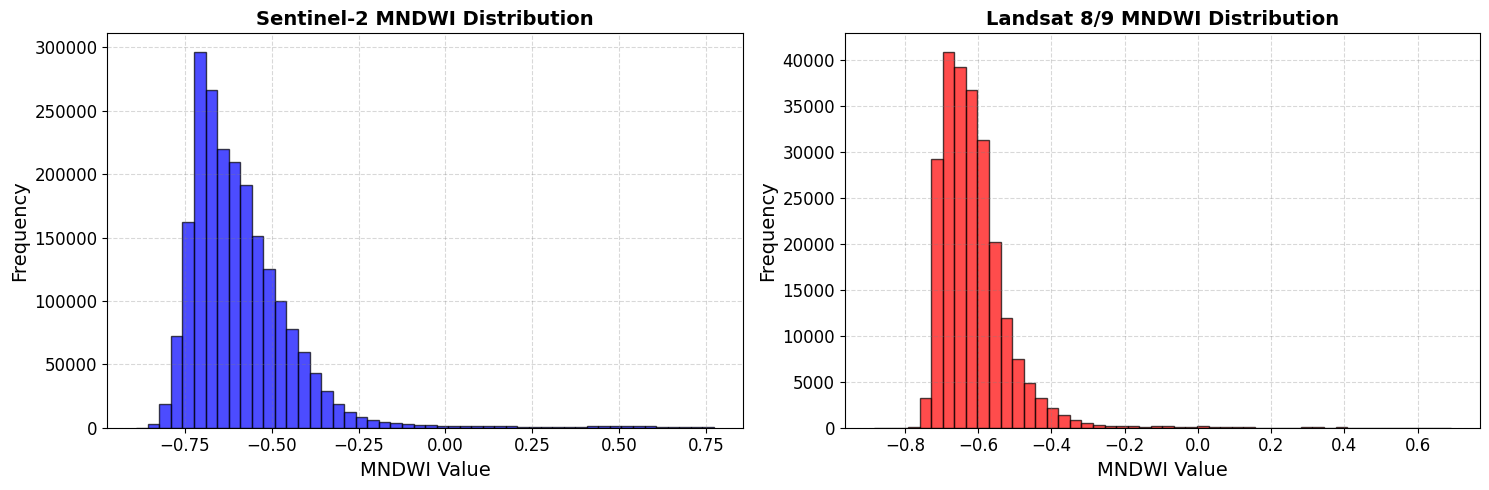

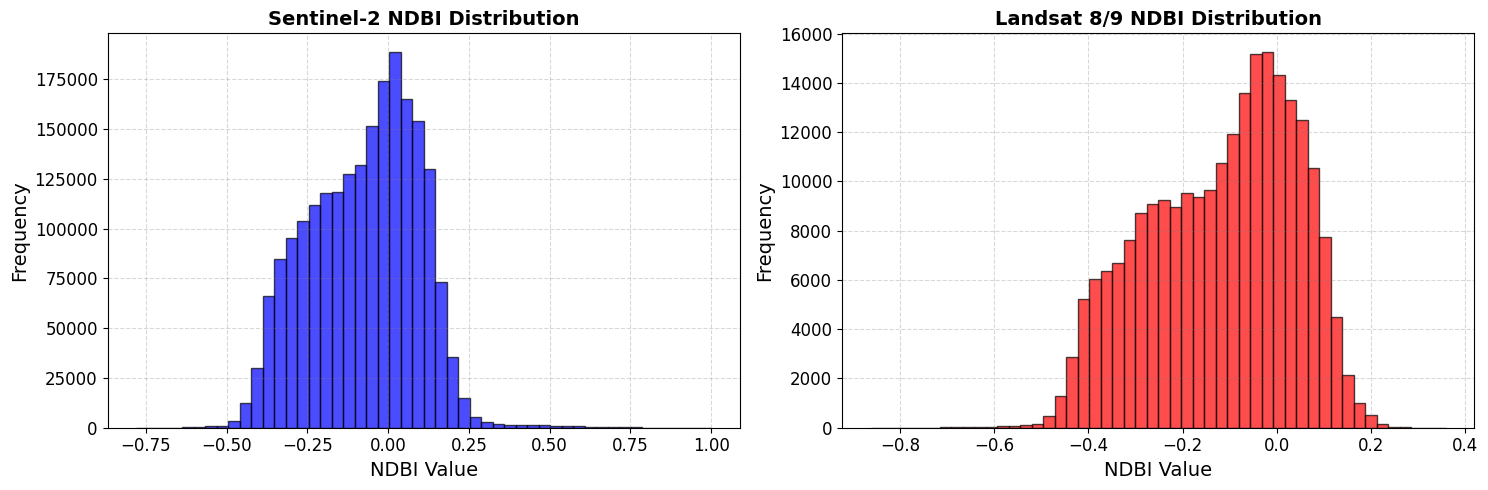

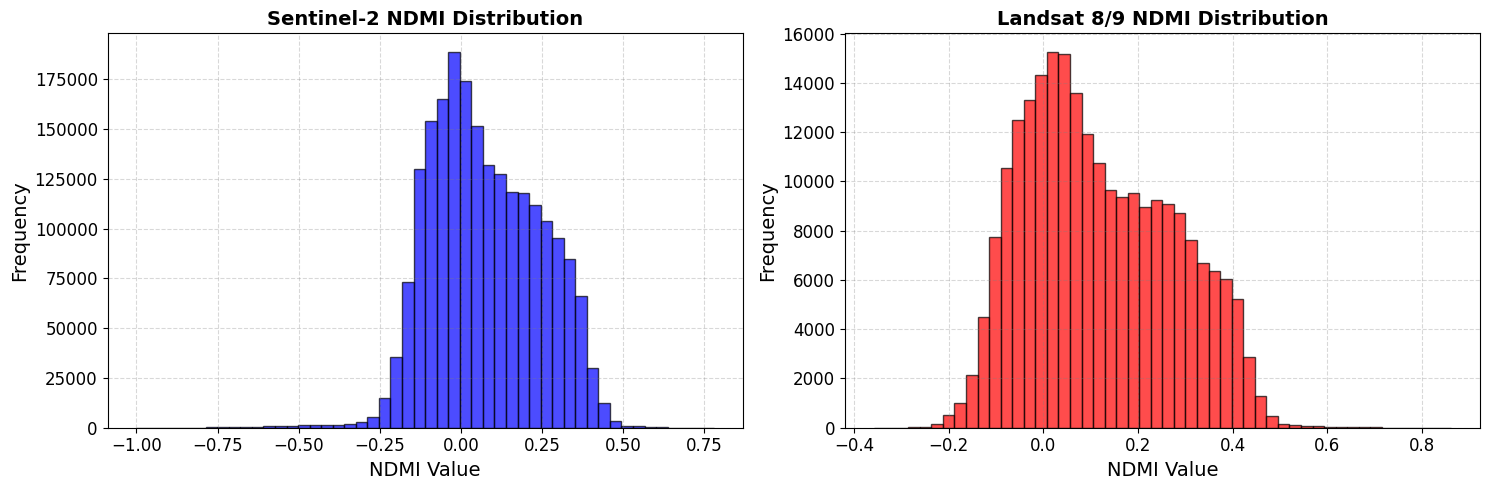

In [ ]:
print("Creating histogram comparisons...")

# Generate histograms for all indices
plot_histogram_comparison(sentinel2_gndvi, landsat_gndvi, "GNDVI")
plot_histogram_comparison(sentinel2_mndwi, landsat_mndwi, "MNDWI")
plot_histogram_comparison(sentinel2_ndbi, landsat_ndbi, "NDBI")
plot_histogram_comparison(sentinel2_ndmi, landsat_ndmi, "NDMI")